### Getting started

In [ ]:
# mounting the dive
from google.colab import drive
drive.mount("/content/gdrive")

# TPU with tesorflow
import tensorflow as tf

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

!pip install -q tensorflow-text
!pip install -q tf-models-official
# !pip install -q tensorflow-
!pip install cmudict

import pandas as pd

import os
import shutil

import cmudict

import seaborn as sns

import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, concatenate, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Reshape, AveragePooling2D, Conv1D, Input, Concatenate, BatchNormalization
import tensorflow.keras as k

from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

import numpy as np

tf.get_logger().setLevel('ERROR')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import Callback 
from sklearn.metrics import classification_report

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

import gensim.downloader as api
gensim_model = api.load("glove-wiki-gigaword-300")

import scipy

import datetime

!pip install scikit-optimize
from skopt.plots import plot_convergence, plot_objective_2D, plot_objective
from skopt.space.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from keras import backend as K
from keras import metrics
# from keras.optimizers import SGD

import random

'''
Functions
'''

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## importing dataset

In [ ]:
import pandas as pd

def mapToLikerScale(num):
  if (num >= 0 and num < 0.2):
    return 0
  if (num >= 0.2 and num < 0.4):
    return 1
  if (num >= 0.4 and num < 0.6):
    return 2
  if (num >= 0.6 and num < 0.8):
    return 3
  if (num >= 0.8 and num < 1):
    return 4
  return 0

def clear2020Dataset(lcp2020):
  lcp2020 = lcp2020.drop(['id', 'corpus'], axis=1)
  lcp2020['complexity'] = lcp2020['complexity'].apply(mapToLikerScale)
  return lcp2020

TRAIN = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2020/train/lcp_single_train.tsv', sep='\t')
TEST = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2020/test/lcp_single_test.tsv', sep='\t')

# used as testing
lcp2018_1_test = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/testset/english/WikiNews_Test.tsv', sep='\t', header=None)
lcp2018_2_test = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/testset/english/Wikipedia_Test.tsv', sep='\t', header=None)
lcp2018_3_test = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/testset/english/News_Test.tsv', sep='\t', header=None)

lcp2018_test = pd.concat([lcp2018_3_test]) # , lcp2018_2_test, lcp2018_3_test, lcp2018_4, lcp2018_5, lcp2018_6])
lcp2018_test.drop([0, 2, 3, 5, 6, 8, 9, 10], axis=1, inplace=True)
# lcp2018_test.drop([0, 2, 3, 5, 6, 7, 8, 10], axis=1, inplace=True)
lcp2018_test.rename(columns = {1:'sentence', 4:'token', 7:'complexity'}, inplace = True) 
# lcp2018_test.rename(columns = {1:'sentence', 4:'token', 9:'complexity'}, inplace = True) 
# To map to the liker scale
lcp2018_test['complexity'] = (lcp2018_test['complexity']/10).apply(mapToLikerScale)
# print(lcp2018_test)
# lcp2018_test['complexity'] = (lcp2018_test['complexity']).apply(lambda x: x == 1)

# used as training
lcp2018_1 = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/traindevset/english/WikiNews_Dev.tsv', sep='\t', header=None)
lcp2018_2 = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/traindevset/english/WikiNews_Train.tsv', sep='\t', header=None)
lcp2018_3 = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/traindevset/english/Wikipedia_Dev.tsv', sep='\t', header=None)
lcp2018_4 = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/traindevset/english/Wikipedia_Train.tsv', sep='\t', header=None)
lcp2018_5 = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/traindevset/english/News_Train.tsv', sep='\t', header=None)
lcp2018_6 = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/traindevset/english/News_Train.tsv', sep='\t', header=None)

lcp2018 = pd.concat([lcp2018_5, lcp2018_6]) # , lcp2018_3, lcp2018_4, lcp2018_5, lcp2018_6])
lcp2018.drop([0, 2, 3, 5, 6, 8, 9, 10], axis=1, inplace=True)
# lcp2018.drop([0, 2, 3, 5, 6, 7, 8, 10], axis=1, inplace=True)
lcp2018.rename(columns = {1:'sentence', 4:'token', 7:'complexity'}, inplace = True) 
# lcp2018.rename(columns = {1:'sentence', 4:'token', 9:'complexity'}, inplace = True) 
# To map to the liker scale
lcp2018['complexity'] = (lcp2018['complexity']/10).apply(mapToLikerScale)
# lcp2018['complexity'] = (lcp2018['complexity']).apply(lambda x: x == 1)

TEST= clear2020Dataset(TEST)
TRAIN = clear2020Dataset(TRAIN)

TRAIN = TRAIN.append(lcp2018, ignore_index=True)
# TRAIN = TRAIN.groupby('token')
# TRAIN = TRAIN.apply(lambda x: x.sample(TRAIN.size().min()).reset_index(drop=True))
# TRAIN = TRAIN.groupby('complexity')
# TRAIN = TRAIN.apply(lambda x: x.sample(TRAIN.size().min()).reset_index(drop=True)).reset_index(drop=True)
# TRAIN = TRAIN.sample(frac = 1).reset_index(drop=True)
# TRAIN = TRAIN.apply(lambda x: x.head(2438).reset_index(drop=True))

# TEST = lcp2018_test
# TRAIN = lcp2018

In [ ]:
lcp2018_2_test = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/testset/english/Wikipedia_Test.tsv', sep='\t', header=None)
lcp2018_3 = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/traindevset/english/Wikipedia_Dev.tsv', sep='\t', header=None)
lcp2018_4 = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/traindevset/english/Wikipedia_Train.tsv', sep='\t', header=None)

lcp2018_3_test = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/testset/english/News_Test.tsv', sep='\t', header=None)
lcp2018_5 = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/traindevset/english/News_Train.tsv', sep='\t', header=None)
lcp2018_6 = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2018/traindevset/english/News_Train.tsv', sep='\t', header=None)

In [ ]:
# used as testing
TRAIN = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2020/train/lcp_single_train.tsv', sep='\t')
TEST = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/2020/test/lcp_single_test.tsv', sep='\t')

wikiNews = pd.concat([TRAIN, TEST])
wikiNews['liker'] = (wikiNews['complexity']).apply(mapToLikerScale)

## POS Tagging for Dataset

In [ ]:
def getPOSofWord(row):
  try:
    wordsList = word_tokenize(row['sentence'])

    # removing stop words from wordList 
    wordsList = [w for w in wordsList if not w in stop_words]
    wordsList = [w.lower() for w in wordsList]
    wordsList_ = []
    for i in wordsList:
      i = i.replace("'", "")
      i = i.replace('+', '')
      i = i.replace(':', '')
      i = i.replace('\u200b', '')
      if len(i.split('–')) != 1:
        wordsList_ = wordsList_ + i.split('–')
      elif len(i.split('-')) != 1:
        wordsList_ = wordsList_ + i.split('-')
      elif len(i.split('/')) != 1:
        wordsList_ = wordsList_ + i.split('/')
      else:
        wordsList_.append(i)


    if (str(row['token']).lower() == 'nan'):
      return 'nan'


    #  Using a Tagger. Which is part-of-speech  
    # tagger or POS-tagger.
    wordsList_ = [x for x in wordsList_ if x]

    indexOfWord = wordsList_.index(row['token'].lower())

    tagged = nltk.pos_tag(wordsList_) 

    return tagged[indexOfWord][1]
  except:
    try:
      wordsList = word_tokenize(row['sentence'])

      # removing stop words from wordList 
      wordsList = [w for w in wordsList if not w in stop_words]
      wordsList = [w.lower() for w in wordsList]

      wordsList = [x for x in wordsList if x]

      indexOfWord = wordsList.index(row['token'].lower())

      tagged = nltk.pos_tag(wordsList)

      return tagged[indexOfWord][1]
    except Exception as e:
      print(e)
      return 'nan'

TRAIN['POS'] = TRAIN.apply(getPOSofWord, axis=1)
TEST['POS'] = TEST.apply(getPOSofWord, axis=1)

print('Number of lost rows:', TRAIN[TRAIN['POS'] == 'nan'].shape[1], '(TRAIN)')
#  removing untagged data
TRAIN = TRAIN[TRAIN['POS'] != 'nan']
TRAIN.reset_index(drop=True, inplace=True)

Change POS to number labeling

In [ ]:
pos = []
def numberString(x):
  if x not in pos:
    pos.append(x)
  return pos.index(x)

TRAIN['POS'] = TRAIN['POS'].apply(numberString)
TEST['POS'] = TEST['POS'].apply(numberString)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Dataset of age of acqusition

In [ ]:
age_of_acqu = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/age of acquisition/AoA_51715_words.csv')
age_of_acqu = age_of_acqu[['Word', 'Nletters', 'Nphon', 'Nsyll', 'AoA_Kup_lem']]
age_of_acqu

,Word,Nletters,Nphon,Nsyll,AoA_Kup_lem
0,a,1,1,1,2.893384
1,aardvark,8,7,2,9.890000
2,abacus,6,6,3,8.690000
3,abacuses,8,9,4,8.690000
4,abalone,7,7,4,12.230000
...,...,...,...,...,...
51710,zucchini,8,6,3,6.790000
51711,zucchinis,9,7,3,6.790000
51712,zwieback,8,6,2,16.100000
51713,zygote,6,5,2,15.380000


In [ ]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def mergeWithAOA(df):
  # Lemmatizing Words for the rest of the information extraction
  df['token'] = df['token'].str.lower().apply(wnl.lemmatize)
  # Renaming words into token for the rest fot eh information extraction
  df.rename(columns = {'token':'Word'}, inplace=True)
  # Merging data needed form AOA dataset
  return df.merge(age_of_acqu, left_on='Word', right_on='Word', how='left') # token

TRAIN = mergeWithAOA(TRAIN);
TEST = mergeWithAOA(TEST);

In [ ]:
# print('Rows lost to getting word aqusition dataset:', str(TRAIN.isna().shape[1], '(TRAIN)'))
TRAIN.dropna(inplace=True)
TRAIN

,id,corpus,sentence,Word,complexity,POS,Nletters,Nphon,Nsyll,AoA_Kup_lem
0,3ZLW647WALVGE8EBR50EGUBPU4P32A,bible,"Behold, there came up out of the river seven c...",river,0.000000,0,5.0,4.0,2.0,4.90
1,34R0BODSP1ZBN3DVY8J8XSIY551E5C,bible,I am a fellow bondservant with you and with yo...,brother,0.000000,1,7.0,5.0,2.0,3.63
2,3S1WOPCJFGTJU2SGNAN2Y213N6WJE3,bible,"The man, the lord of the land, said to us, 'By...",brother,0.050000,1,7.0,5.0,2.0,3.63
3,3BFNCI9LYKQN09BHXHH9CLSX5KP738,bible,Shimei had sixteen sons and six daughters; but...,brother,0.150000,1,7.0,5.0,2.0,3.63
4,3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2,bible,He has put my brothers far from me.\tbrothers\...,son,0.055556,1,3.0,3.0,1.0,3.78
...,...,...,...,...,...,...,...,...,...,...
7219,3P6ENY9P79WZJ1ZCVTA874JG29VIH6,europarl,I therefore call on the Commission and the Mem...,austerity,0.640625,2,9.0,8.0,4.0,16.79
7221,3DA79LNS59VAY78OAKKAHHKFUNET3G,europarl,I think it is very important to add that more ...,boatswain,0.650000,2,9.0,7.0,2.0,14.64
7222,37NXA7GVST66R322LLOPEL2HRRKLVV,europarl,Since certain comments have been made on this ...,shank,0.656250,9,5.0,4.0,1.0,11.89
7223,31S7M7DAGGQREBYDGQOAD3EWU7KTL5,europarl,The struggle against global Islamic terrorism ...,jurisprudence,0.671875,2,13.0,12.0,4.0,16.20


## Frequicy Dataset

In [ ]:
freq = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/word frequencies/unigram_freq.csv').rename(columns={'word':'Word'})

TRAIN = TRAIN.merge(freq, left_on='Word', right_on='Word', how='left') # token
TEST = TEST.merge(freq, left_on='Word', right_on='Word', how='left') # token

print('Rows lost to getting word aqusition dataset:', str(TRAIN.isna().shape[1]), '(TRAIN)')
TRAIN.dropna(inplace=True)
TRAIN

Rows lost to getting word aqusition dataset: 11 (TRAIN)


,id,corpus,sentence,Word,complexity,POS,Nletters,Nphon,Nsyll,AoA_Kup_lem,count
0,3ZLW647WALVGE8EBR50EGUBPU4P32A,bible,"Behold, there came up out of the river seven c...",river,0.000000,0,5.0,4.0,2.0,4.90,78843808.0
1,34R0BODSP1ZBN3DVY8J8XSIY551E5C,bible,I am a fellow bondservant with you and with yo...,brother,0.000000,1,7.0,5.0,2.0,3.63,34273892.0
2,3S1WOPCJFGTJU2SGNAN2Y213N6WJE3,bible,"The man, the lord of the land, said to us, 'By...",brother,0.050000,1,7.0,5.0,2.0,3.63,34273892.0
3,3BFNCI9LYKQN09BHXHH9CLSX5KP738,bible,Shimei had sixteen sons and six daughters; but...,brother,0.150000,1,7.0,5.0,2.0,3.63,34273892.0
4,3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2,bible,He has put my brothers far from me.\tbrothers\...,son,0.055556,1,3.0,3.0,1.0,3.78,58094311.0
...,...,...,...,...,...,...,...,...,...,...,...
6237,3P6ENY9P79WZJ1ZCVTA874JG29VIH6,europarl,I therefore call on the Commission and the Mem...,austerity,0.640625,2,9.0,8.0,4.0,16.79,215350.0
6238,3DA79LNS59VAY78OAKKAHHKFUNET3G,europarl,I think it is very important to add that more ...,boatswain,0.650000,2,9.0,7.0,2.0,14.64,110994.0
6239,37NXA7GVST66R322LLOPEL2HRRKLVV,europarl,Since certain comments have been made on this ...,shank,0.656250,9,5.0,4.0,1.0,11.89,1311484.0
6240,31S7M7DAGGQREBYDGQOAD3EWU7KTL5,europarl,The struggle against global Islamic terrorism ...,jurisprudence,0.671875,2,13.0,12.0,4.0,16.20,1376456.0


## Definitions count of words

In [ ]:
definitions = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/definitions datasets/definitions_count.csv')

definitions.rename(columns={"token": "Word"}, inplace=True)


TRAIN = TRAIN.merge(definitions, left_on='Word', right_on='Word', how='left') # token
TEST = TEST.merge(definitions, left_on='Word', right_on='Word', how='left') # token

TEST.fillna(1, inplace=True)
TRAIN.fillna(1, inplace=True)

## Compound count Words

In [ ]:
compound_count = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/compound words/compound_count.csv')
compound_count.rename(columns={"token": "Word"}, inplace=True)
TRAIN = TRAIN.merge(compound_count, left_on='Word', right_on='Word', how='left') # token
TEST = TEST.merge(compound_count, left_on='Word', right_on='Word', how='left') # token
TEST.fillna(1, inplace=True)
TRAIN.fillna(1, inplace=True)

## MRC Dataset

In [ ]:
MRC = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/MRC/MRC_DIC.csv')
MRC = MRC[['WORD', 'CNC', 'FAM', 'IMG', 'CMEAN']]
MRC = MRC.groupby(['WORD']).agg({'CNC': ['mean'], 'FAM': ['mean'], 'IMG': ['mean'], 'CMEAN': ['mean']}).reset_index()
MRC.rename(columns={'WORD':'Word'}, inplace=True)
MRC['Word'] = MRC['Word'].str.lower()

TRAIN = TRAIN.merge(MRC, left_on='Word', right_on='Word', how='left') # token
TEST = TEST.merge(MRC, left_on='Word', right_on='Word', how='left') # token

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


## Prefixs and Suffixs

In [ ]:
affixs = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/affix count/affix_count.csv')

def getPre(x):
  return x.split(',')[0]

def getSuf(x):
  return x.split(',')[-1]

affixs['prefix_count'] = affixs['afflix  count'].apply(getPre)
affixs['suffix_count'] = affixs['afflix  count'].apply(getSuf)
affixs = affixs[['token', 'prefix_count', 'suffix_count']]
affixs.rename(columns={'token': 'Word'}, inplace=True)
affixs['Word'] = affixs['Word'].str.lower()
affixs.fillna(0, inplace=True)
TRAIN = TRAIN.merge(affixs, left_on='Word', right_on='Word', how='left')
TEST = TEST.merge(affixs, left_on='Word', right_on='Word', how='left')
TRAIN['prefix_count'].fillna(0, inplace=True)
TRAIN['suffix_count'].fillna(0, inplace=True)
TEST['prefix_count'].fillna(0, inplace=True)
TEST['suffix_count'].fillna(0, inplace=True)

## Statictilcaty assumptions (NEED TO BE ADDED)

In [ ]:
# TRAIN = TRAIN.drop(['sentence'], axis=1)
# TEST = TEST.drop(['sentence'], axis=1)
TRAIN_AND_TEST = pd.concat([TRAIN, TEST])

datasetNoNa = TRAIN_AND_TEST.dropna()

## Assumption of missing values: Using imaginability (IMG) to get Concentness (CNC)

words that are being accomodated For

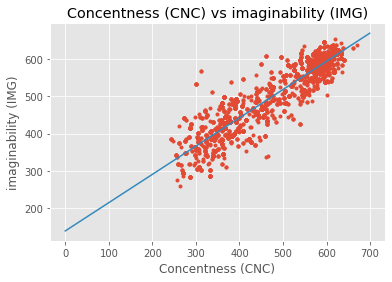

In [ ]:
col_1 = datasetNoNa[('CNC', 'mean')].values
col_2 = datasetNoNa[('IMG', 'mean')].values
x_ = col_1.reshape(col_1.shape[0])
y_ = col_2.reshape(col_2.shape[0])
result_IMG_CNC = scipy.stats.linregress(x_, y_)

x_vals = np.arange(700)
y_vals = result_IMG_CNC.intercept + result_IMG_CNC.slope * x_vals

plt.plot(x_, y_, '.')
plt.plot(x_vals, y_vals, '-')
plt.title('Concentness (CNC) vs imaginability (IMG)')
plt.xlabel('Concentness (CNC)')
plt.ylabel('imaginability (IMG)')
plt.show()
# save image

## Assumption of missing values: Using age of acquisition (AOA) to get Familiarity (FAM)

In [ ]:
print('words that are being accounted for in Using age of acquisition (AOA) to get Familiarity (FAM):', TRAIN_AND_TEST[TRAIN_AND_TEST[('FAM', 'mean')].replace(np.NaN, 0) == 0].shape[1], '(train and test)')

words that are being accounted for in Using age of acquisition (AOA) to get Familiarity (FAM): 19 (train and test)


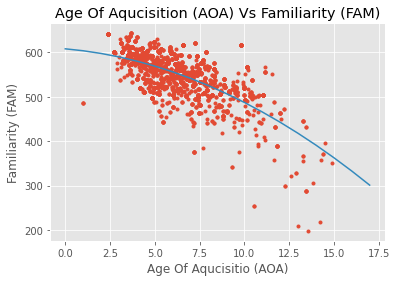

In [ ]:
col_1 = datasetNoNa['AoA_Kup_lem'].values
col_2 = datasetNoNa[('FAM', 'mean')].values

x_ = col_1.reshape(col_1.shape[0])
y_ = col_2.reshape(col_2.shape[0])

result = scipy.stats.linregress(x_, y_)
mod = np.poly1d(np.polyfit(x_, y_, 2))

axes = plt.gca()
x_vals = np.arange(18)
plt.plot(x_, y_, '.')
plt.plot(x_vals, mod(x_vals), '-')
plt.title('Age Of Aqucisition (AOA) Vs Familiarity (FAM)')
plt.xlabel('Age Of Aqucisitio (AOA)')
plt.ylabel('Familiarity (FAM)')
plt.show()

### Assumption of missing values: Using Age of Acqusition (AOA) to get Meaning (CMEAN)

In [ ]:
print('words that are being accounted for in Using age of acquisition (AOA) to get Meaning (CMEAN):', TRAIN_AND_TEST[TRAIN_AND_TEST[('CMEAN', 'mean')].replace(np.NaN, 0) == 0].shape[1], '(train and test)')

words that are being accounted for in Using age of acquisition (AOA) to get Meaning (CMEAN): 19 (train and test)


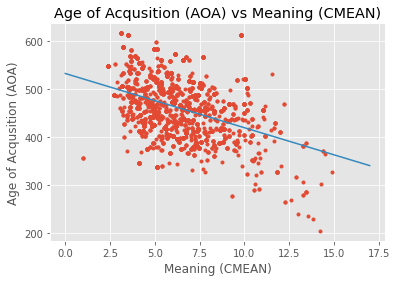

In [ ]:
col_1 = datasetNoNa['AoA_Kup_lem'].values
col_2 = datasetNoNa[('CMEAN', 'mean')].values
x_ = col_1.reshape(col_1.shape[0])
y_ = col_2.reshape(col_2.shape[0])

res = scipy.stats.pearsonr(x_, y_)
result_AOA_CMEAN = scipy.stats.linregress(x_, y_)

x_vals = np.arange(18)
y_vals = result_AOA_CMEAN.intercept + result_AOA_CMEAN.slope * x_vals

plt.plot(x_, y_, '.')
plt.plot(x_vals, y_vals, '-')
plt.title('Age of Acqusition (AOA) vs Meaning (CMEAN)')
plt.xlabel('Meaning (CMEAN)')
plt.ylabel('Age of Acqusition (AOA)')
plt.show()

### Assumption of missing values: Using the finding and adding them into the dataset

In [ ]:
def fillCMEAN(row):
  if np.isnan(row[('CMEAN', 'mean')]):
    row[('CMEAN', 'mean')] = result_AOA_CMEAN.intercept + result_AOA_CMEAN.slope * row['AoA_Kup_lem']
  return row

def fillFAM(row):
  if np.isnan(row[('FAM', 'mean')]):
    row[('FAM', 'mean')] = mod(row['AoA_Kup_lem'])
  return row

def fillCNC(row):
  if np.isnan(row[('CNC', 'mean')]):
    row[('CNC', 'mean')] = result_IMG_CNC.intercept + result_IMG_CNC.slope * row[('IMG', 'mean')]
  return row

TRAIN = TRAIN.apply(fillCMEAN, axis=1)
TEST = TEST.apply(fillCMEAN, axis=1)
TRAIN = TRAIN.apply(fillFAM, axis=1)
TEST = TEST.apply(fillFAM, axis=1)
TRAIN = TRAIN.apply(fillCNC, axis=1)
TEST = TEST.apply(fillCNC, axis=1)

Dropping Colums Imaginability and Meaning Too many unnouns

In [ ]:
TRAIN = TRAIN.drop([('IMG', 'mean'), ('CNC', 'mean')], axis=1).dropna()
TEST = TEST.drop([('IMG', 'mean'), ('CNC', 'mean')], axis=1).dropna()

## Mapping out all the colums as charts 

In [ ]:
# sns.pairplot(datasetNoNa[['Word', 'complexity',	'POS',	'AoA_Kup_lem',	'count',	'definitions',	'compoundCount',	('FAM', 'mean'), ('CMEAN', 'mean'),	'prefix_count',	'suffix_count']], hue="complexity")

## Syllables Dataset

In [ ]:
def replaceZerosSyll(row):
  replace_word = ''
  first_word = True
  for i, word in enumerate(row[1].split(' ')):
    if not first_word:
        replace_word = replace_word + ' '
    if word == '0':
      replace_word = replace_word + str(row[0].split(' ')[i])
    else:
      replace_word = replace_word + str(word)
    first_word = False
  return replace_word

In [ ]:
syllables = pd.read_csv('/content/gdrive/MyDrive/thesis 2020/Datasets/syllable/syllable_word.csv')
syllables['syllable'] = syllables.apply(replaceZerosSyll, axis=1)
syllables

,token,syllable
0,river,riv-​er
1,brothers,broth-​er
2,sons,sons
3,days,days
4,lion,li-​on
...,...,...
13497,Relations,re-​la-​tion
13498,hard pressed,hard pressed
13499,pressed,pressed
13500,effective,ef-​fec-​tive


In [ ]:
sylls = []
syllToNumber = {}
words_sylls_in_encoding = {}


for row in syllables.values:
  words_with_syll = row[1]
  for word in str(words_with_syll).split(' '):
    word_syll_encoded = []
    for syll in word.split('-'):
      syll = syll.strip(u'\u200b')
      if syll not in sylls:
        syllToNumber[syll] = len(sylls)
        word_syll_encoded.append(len(sylls))
        sylls.append(syll) 
      else:
        word_syll_encoded.append(syllToNumber[syll])
  words_sylls_in_encoding[row[0]] = word_syll_encoded

## Words to Phone Encoding

In [ ]:
phoneToNumber = {}
numberToPhone = {}

# Getting Phones with out extra information
phones = [x[0] for x in cmudict.phones()]

# for each phone adding possable stress notations
phonesWithStress = []
for phone in phones:
  phonesWithStress.append(phone)
  phonesWithStress.append(phone+'0')
  phonesWithStress.append(phone+'1')
  phonesWithStress.append(phone+'2')

# for each phone (with stress) map them to a character
for x, phone in enumerate(phonesWithStress):
  phoneToNumber[phone] = x
  numberToPhone[x] = phone

# adding unkown tag to the dictionary 
numberToPhone['<unk>'] = '<unk>'
phoneToNumber['<unk>'] = '<unk>'

# adding spaces tag to the dictionary 
numberToPhone[' '] = ' '
phoneToNumber[' '] = ' '

In [ ]:
# Getting words avalable in CMU Dictionary
words_cmu = [x[0] for x in cmudict.entries()]

# Getting the words Phonemes from the CMU Dictionary
wordPhonemes = [x[1] for x in cmudict.entries()]

# Global functions (phones as there char ref)
# words to phonemes as Arrays
wordsTranslatedToIntPhonemesArr = {}
# words to phonemes as strings
wordsTranslatedToPhonemes = {}
# Phonemes to words as strings
phonemesTranslatedToWords = {}

#  'PhonesChars' refs to phone as there char ref
for phonemes, word in zip(wordPhonemes, words_cmu):
  stringOfPhonesChars = ''
  arrOfPhonesChars = []
  for phone in phonemes:
    # stringOfPhonesChars = stringOfPhonesChars + phoneToNumber[phone]
    arrOfPhonesChars.append(phoneToNumber[phone])

  wordsTranslatedToPhonemes[word] = stringOfPhonesChars
  phonemesTranslatedToWords[stringOfPhonesChars] = word
  wordsTranslatedToIntPhonemesArr[word] = arrOfPhonesChars

# Getting lengths of words in phonemes
phonemes_len = [len(z) for z in wordsTranslatedToIntPhonemesArr.values()]
# longest phoneme word
longest_sounded_word = max(phonemes_len)

In [ ]:
wordsTranslatedToIntPhonemesArr

{"'bout": [24, 18, 120],
 "'cause": [76, 9, 148],
 "'course": [76, 14, 108, 112],
 "'cuse": [76, 144, 134, 148],
 "'em": [9, 84],
 "'frisco": [52, 108, 66, 112, 76, 97],
 "'gain": [56, 42, 88],
 "'kay": [76, 50],
 "'m": [9, 84],
 "'n": [9, 88],
 "'round": [108, 18, 88, 32],
 "'s": [42, 112],
 "'til": [120, 66, 80],
 "'tis": [120, 66, 148],
 "'twas": [120, 140, 10, 148],
 'a': [50],
 "a's": [50, 148],
 'a.': [50],
 "a.'s": [50, 148],
 'a.d.': [51, 32, 70],
 'a.m.': [51, 42, 84],
 'a.s': [50, 148],
 'aaa': [120, 108, 67, 104, 9, 80, 50],
 'aaberg': [2, 24, 45, 56],
 'aachen': [2, 76, 9, 88],
 'aachener': [2, 76, 9, 88, 45],
 'aaker': [2, 76, 45],
 'aalborg': [2, 80, 24, 13, 108, 56],
 'aalburg': [6, 80, 24, 45, 56],
 'aalen': [2, 80, 9, 88],
 'aaliyah': [3, 80, 70, 3],
 'aalseth': [2, 80, 112, 41, 124],
 'aalsmeer': [2, 80, 112, 84, 65, 108],
 'aalto': [2, 80, 120, 99],
 'aamodt': [2, 84, 9, 120],
 'aancor': [2, 88, 76, 15, 108],
 'aardema': [1, 108, 32, 42, 84, 9],
 'aardvark': [2, 108,

## Letters to Consonants and Vowels

In [ ]:
vowels = ['a', 'ä', 'å', 'á', 'e', 'é', 'è', 'ê', 'ë', 'i', 'í', 'ī', 'o', 'ó', 'u', 'ü']
consonants = ['b', 'c', 'ç', 'd', 'f', 'g', 'h', 'ḥ', 'j', 'k', 'l', 'm', 'n', 'ñ', 'ń', 'p', 'q', 'r', 's', 't',  'v', 'w', 'x', 'z', 'ż']
both = 'y'

combinationns = []
#  Y rules to be a vowel
# The word has no other vowel: gym, my.
# The letter is at the end of a word or syllable: candy, deny, bicycle, acrylic.
# The letter is in the middle of a syllable: system, borborygmus.
def wordToWordCV(words):
  words = words.lower()
  wordCV = []
  for word in words.split(' '):
    syllablesCV = []
    for syll in word.split('-'):
      syllableCV_ = ''
      syll = syll.strip(u'\u200b').strip('(').strip("'")
      if syll != '':
        for letter in syll:
          syllableCV_ = syllableCV_ + isVowelOrConsonat(letter)
          syllableCV_ = placeY(syllableCV_)
        syllablesCV.append(syllableCV_)
    if syllableCV_ not in combinationns:
      combinationns.append(syllableCV_)
    wordCV.append('-'.join(syllablesCV))

  return ' '.join(wordCV)

def isVowelOrConsonat(letter):
  if letter in vowels:
    return 'v'
  if letter in consonants:
    return 'c'
  if letter in both:
    return 'x'
  return ''

def placeY(cvx):
  lenght = len(cvx)
  center = int(lenght/2)
  xPos = []
  consonants = 0
  vowels = 0
  for i, j in enumerate(cvx):
    if j == 'x':
      if i+1 == lenght:
        cvx_ = list(cvx)
        cvx_[i] = 'v'
        cvx = ''.join(cvx_)
      elif lenght%2 == 1 and i == center:
        cvx_ = list(cvx)
        cvx_[i] = 'v'
        cvx = ''.join(cvx_)
      else:
        xPos.append(i)
    if j == 'c':
      consonants = consonants + 1
    if j == 'v':
      vowels = vowels + 1
  if len(xPos) != 0:
    if vowels != 0:
      for x in xPos:
        cvx_ = list(cvx)
        cvx_[x] = 'c'
        cvx = ''.join(cvx_)
    else:
      for x in xPos:
        cvx_ = list(cvx)
        cvx_[x] = 'v'
        cvx = ''.join(cvx_)
  return cvx

syllables['Consonants and Vowels'] = syllables['syllable'].apply(wordToWordCV)
syllables

,token,syllable,Consonants and Vowels
0,river,riv-​er,cvc-vc
1,brothers,broth-​er,ccvcc-vc
2,sons,sons,cvcc
3,days,days,cvvc
4,lion,li-​on,cv-vc
...,...,...,...
13497,Relations,re-​la-​tion,cv-cv-cvvc
13498,hard pressed,hard pressed,cvcc ccvccvc
13499,pressed,pressed,ccvccvc
13500,effective,ef-​fec-​tive,vc-cvc-cvcv


In [ ]:
syllables

,token,syllable,Consonants and Vowels
0,river,riv-​er,cvc-vc
1,brothers,broth-​er,ccvcc-vc
2,sons,sons,cvcc
3,days,days,cvvc
4,lion,li-​on,cv-vc
...,...,...,...
13497,Relations,re-​la-​tion,cv-cv-cvvc
13498,hard pressed,hard pressed,cvcc ccvccvc
13499,pressed,pressed,ccvccvc
13500,effective,ef-​fec-​tive,vc-cvc-cvcv


word syllables to encoded consents and vowels patters

In [ ]:
cvs = []
cvToNumber = {}
words_cv_sylls_in_encoding = {}


for row in syllables.values:
  words_with_cv = row[2]
  for word in str(words_with_cv).split(' '):
    word_cv_encoded = []
    for cv in word.split('-'):
      cv = cv.strip(u'\u200b')
      if cv not in cvs:
        cvToNumber[cv] = len(cvs)
        word_cv_encoded.append(len(cvs))
        cvs.append(cv) 
      else:
        word_cv_encoded.append(cvToNumber[cv])
  words_cv_sylls_in_encoding[row[0]] = word_cv_encoded

cv_syllable_len = [len(z) for z in cvs]
longest_cv_word = max(cv_syllable_len)

words_cv_sylls_in_encoding

{'river': [0, 1],
 'brothers': [2, 1],
 'sons': [3],
 'days': [4],
 'lion': [5, 1],
 'fire': [6],
 'disease': [0, 7],
 'everyone': [1, 8, 8],
 'knees': [9],
 'speech': [10],
 'name': [6],
 'Father': [5, 11],
 'waters': [5, 3],
 'sign': [3],
 'wood': [4],
 'gold': [3],
 'weep': [4],
 'silver': [0, 0],
 'cause': [12],
 'cities': [13],
 'crop': [11],
 'hair': [4],
 'kings': [14],
 'cloth': [2],
 'hands': [14],
 'words': [14],
 'fish': [3],
 'clouds': [10],
 'mountain': [4, 4],
 'images': [1, 8],
 'trust': [2],
 'subject': [0, 3],
 'search': [15],
 'iron': [16],
 'stones': [17],
 'nothing': [3, 18],
 'fruit': [9],
 'nights': [19],
 'finger': [0, 0],
 'eyes': [20],
 'Israel': [1, 5, 1],
 'prayer': [21, 1],
 'power': [0, 1],
 'Benjamin': [0, 5, 0],
 'blessing': [2, 18],
 'throne': [22],
 'faith': [23],
 'rest': [3],
 'crown': [2],
 'truth': [2],
 'play': [21],
 'world': [14],
 'side': [6],
 'drink': [2],
 'faces': [24],
 'order': [1, 0],
 'honor': [0, 1],
 'refuge': [0, 8],
 'north': [14],
 

letter syllables to binary patters

In [ ]:
cvs_letters = []
words_cv_letters_in_encoding = {}

for row in syllables.values:
  words_with_cv = row[2].strip(u'\u200b')
  letters_cv_encoded = []
  for letter in words_with_cv.strip('-'):
    if letter == ' ':
      letters_cv_encoded.append(0)
    else:
      letters_cv_encoded.append(2 if letter == 'c' else 1)
  cvs_letters.append(letters_cv_encoded)
  words_cv_letters_in_encoding[row[0]] = letters_cv_encoded

cv_letter_len = [len(z) for z in cvs_letters]
longest_cv_letter_len = max(cv_letter_len)

words_cv_letters_in_encoding

{'river': [2, 1, 2, 1, 1, 2],
 'brothers': [2, 2, 1, 2, 2, 1, 1, 2],
 'sons': [2, 1, 2, 2],
 'days': [2, 1, 1, 2],
 'lion': [2, 1, 1, 1, 2],
 'fire': [2, 1, 2, 1],
 'disease': [2, 1, 2, 1, 1, 1, 2, 1],
 'everyone': [1, 2, 1, 1, 2, 1, 1, 1, 2, 1],
 'knees': [2, 2, 1, 1, 2],
 'speech': [2, 2, 1, 1, 2, 2],
 'name': [2, 1, 2, 1],
 'Father': [2, 1, 1, 2, 2, 1, 2],
 'waters': [2, 1, 1, 2, 1, 2, 2],
 'sign': [2, 1, 2, 2],
 'wood': [2, 1, 1, 2],
 'gold': [2, 1, 2, 2],
 'weep': [2, 1, 1, 2],
 'silver': [2, 1, 2, 1, 2, 1, 2],
 'cause': [2, 1, 1, 2, 1],
 'cities': [2, 1, 2, 1, 1, 2],
 'crop': [2, 2, 1, 2],
 'hair': [2, 1, 1, 2],
 'kings': [2, 1, 2, 2, 2],
 'cloth': [2, 2, 1, 2, 2],
 'hands': [2, 1, 2, 2, 2],
 'words': [2, 1, 2, 2, 2],
 'fish': [2, 1, 2, 2],
 'clouds': [2, 2, 1, 1, 2, 2],
 'mountain': [2, 1, 1, 2, 1, 2, 1, 1, 2],
 'images': [1, 2, 1, 1, 2, 1],
 'trust': [2, 2, 1, 2, 2],
 'subject': [2, 1, 2, 1, 2, 1, 2, 2],
 'search': [2, 1, 1, 2, 2, 2],
 'iron': [1, 2, 1, 2],
 'stones': [2, 2, 1,

## Spliting dataset to multiple inputs (x) and target (y)


### Normalising the dataset

In [ ]:
TEST

In [ ]:
TRAIN.iloc[:,4:]

In [ ]:
TRAIN

In [ ]:
min_max_scaler = MinMaxScaler()
TRAIN_AND_TEST_transformed = min_max_scaler.fit_transform(TRAIN_AND_TEST.iloc[:,4:])
# TRAIN_ = TRAIN
# TEST_ = TEST
TRAIN_.iloc[:,2:] = min_max_scaler.transform(TRAIN.iloc[:,4:])
TEST_.iloc[:,2:] = min_max_scaler.transform(TEST.iloc[:,4:])
TRAIN = TRAIN[['Word', 'complexity',	'POS',	'Nletters',	'Nphon',	'Nsyll',	'AoA_Kup_lem',	'count',	'definitions',	'compoundCount']]
TEST = TEST[['Word', 'complexity',	'POS',	'Nletters',	'Nphon',	'Nsyll',	'AoA_Kup_lem',	'count',	'definitions',	'compoundCount']]
# TEST_

### Spliting into inputs (x) and target (y)

In [ ]:
x_train = TRAIN.drop(['complexity'], axis=1).values
y_train = TRAIN.complexity.values
y_train = np.array(y_train).astype(np.float32)

x_test = TEST.drop(['complexity'], axis=1).values
y_test = TEST.complexity.values
y_test = np.array(y_test).astype(np.float32)

### X ONE (WORDS)

Getting words from the embedding

In [ ]:
x_train

In [ ]:
from nltk.stem.snowball import *
stemmer = SnowballStemmer("english")

# embeddings_dict = {}
# with open("/content/gdrive/MyDrive/thesis 2020/Datasets/embeddings/word embeddings/Glove/glove.6B.300d.txt", 'r') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vector = np.asarray(values[1:], "float32")
#         embeddings_dict[word] = vector

# Getting input words of x 
def x_one(x, type_):
  words = x[:,1:2].tolist()
  x_1 = []
  words_pos_not_found = []
  for pos, word in enumerate(words):
    try:
      x_1.append(gensim_model.get_vector(word[0]).tolist())
    except Exception as e:
      try:
        x_1.append(gensim_model.get_vector(stemmer.stem(word[0])).tolist())
      except Exception as e:
        # make random embedding
        words_pos_not_found.append(pos)
        print(e, type_)
  print(len(x_1))
  x_1 = np.array(x_1)
  print(x_1.shape)
  x_1 = x_1.reshape(x_1.shape[0], 1, x_1.shape[1])
  return x_1, words_pos_not_found

x_train_1, words_not_found_train = x_one(x_train, 'train')
x_test_1, words_not_found_test = x_one(x_test, 'test')

x_1 = np.concatenate([x_train_1, x_test_1])

print('x_train_1 shape', x_train_1.shape, 'x_test_1 shape', x_test_1.shape)

In [ ]:
def remove_for(x, y, pos_of_words_not_found):
  for index in pos_of_words_not_found[::-1]:
    x = np.delete(x, index, 0)
    y = np.delete(y, index, 0)
  return x, y

# removing words that where not found in the embedding
x_train, y_train = remove_for(x_train, y_train, words_not_found_train)
x_test, y_test = remove_for(x_test, y_test, words_not_found_test)

### X TWO (SCALED FLOATS)

In [ ]:
x = np.concatenate([x_train, x_test])

min_max_scaler = preprocessing.MinMaxScaler()
min_max_x_2 = min_max_scaler.fit(x[:,2:])

x_train_2 = min_max_x_2.transform(x_train[:,2:])
x_test_2 = min_max_x_2.transform(x_test[:,2:])

x_2 = np.concatenate([x_train_2, x_test_2])

### X Three (CHAR AS ONE HOT ENCODING)

In [ ]:
def numberToHotEncoding(x, dataset):
  hotencoding = np.repeat(0, len(dataset))
  if x == -1:
    return hotencoding
  else:
    hotencoding[x] = 1
    return np.array(hotencoding).astype(np.float32)

def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='empty')


In [ ]:
# get list of words
words = x[:,1:2].reshape(x[:,1:2].shape[0])

chars = sorted(list(set(''.join([str(word) for word in set(words.tolist())]))))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# setting random numbers in each embeddings
embedding_random = {}
for char in chars:
  if char not in embedding_random:
    embedding_random[char] = np.random.rand(150)

word_lenghts = [len(list(str(word))) for word in words]
larges_word = max(word_lenghts)

def x_three(x_):
  words_re = x_[:,1:2].reshape(x_[:,1:2].shape[0])

  x_chars = [list(str(char)) for char in words_re]

  x_char_indices = np.zeros((len(x_chars), larges_word))
  for x, word in enumerate(x_chars):
    word_chars_indices = [char_indices[char] for char in word]
    x_char_indices[x] = np.append(np.array(word_chars_indices), np.repeat(-1, larges_word - len(word_chars_indices)))
  x_char_indices

  # Hot encoding
  # x_3 = np.zeros((len(x_chars), larges_word, len(chars)))
  # for i, word_indices in enumerate(x_char_indices):
  #   for j, char_int in enumerate(word_indices):
  #     x_3[i, j] = numberToHotEncoding(int(char_int), chars)

  # Embeddings with random numbers
  x_3 = np.random.rand(len(x_chars), larges_word, 150)
  for i, word in enumerate(x_chars):
    for j, char in enumerate(word):
      x_3[i, j] = embedding_random[char]
  print(x_3)

  return x_3

x_train_3  = x_three(x_train)
x_test_3 = x_three(x_test)

x_3 = np.concatenate([x_train_3, x_test_3])

### X Four (Phoneme to One Hot Encoding)

In [ ]:
'''
pass the sentences as array, with in that sentence an array of words
phoneCharAsArray is set if the out come of the word is an array or a string phone phonemes put together
'''
def wordsToHotEncodingPhone(words):
  x_phonemes = np.zeros((len(words), longest_sounded_word, len(phoneToNumber)))
  for i, word in enumerate(words):
      try:
        phonemesAsHotEncoding = []
        for encodedPhone in wordsTranslatedToIntPhonemesArr[word]:
          x_phonemes[i] = numberToHotEncoding(encodedPhone, phoneToNumber)
      except KeyError as e:
        # for the whole word mark as zeros for now
        pass
  return x_phonemes

def wordsToEmbedding(words):
  x_phonemes = np.random.rand(len(words), longest_sounded_word, 150)
  for i, word in enumerate(words):
    phonemesAsHotEmbedding = []
    try:
        phonemesAsHotEncoding = []
        for j, encodedPhone in enumerate(wordsTranslatedToIntPhonemesArr[word]):
          x_phonemes[i, j] = embedding_phoneme_random[encodedPhone]
    except KeyError as e:
        # leave the whole word mark as random
        pass
  return x_phonemes

In [ ]:
#  getting words
x_train_words_re = x_train[:,1:2].reshape(x_train[:,1:2].shape[0])
x_test_words_re = x_test[:,1:2].reshape(x_test[:,1:2].shape[0])

#  getting sentences
x_train_sent_re = x_train[:,:1].reshape(x_train[:,:1].shape[0])
x_test_sent_re = x_test[:,:1].reshape(x_test[:,:1].shape[0])

# setting random numbers in each embeddings
embedding_phoneme_random = {}
for phone in numberToPhone:
  embedding_phoneme_random[phone] = np.random.rand(150)

# setting training data with embedding
x_train_4 = wordsToEmbedding(x_train_words_re)
x_test_4 = wordsToEmbedding(x_test_words_re)

# hot encoding
# x_train_4 = wordsToHotEncodingPhone(x_train_words_re)
# x_test_4 = wordsToHotEncodingPhone(x_test_words_re)

x_4 = np.concatenate([x_train_4, x_test_4])

### X FIVE (Syllable to One Hot Encoding)

In [ ]:
words_sylls_lens = [len(i) for i in words_sylls_in_encoding.values()]
longest_syll_word = max(words_sylls_lens)

In [ ]:
'''
pass the sentences as array, with in that sentence an array of words
phoneCharAsArray is set if the out come of the word is an array or a string phone phonemes put together
'''
def wordsToHotEncodingSyll(words):
  x_syllable = np.zeros((len(words), longest_syll_word, len(cvToNumber)))
  for i, word in enumerate(words):
      try:
        for encodedSyll in words_sylls_in_encoding[word]:
          x_syllable[i] = numberToHotEncoding(encodedPhone, syllToNumber)
      except KeyError as e:
        # for the whole word mark as zeros for now
        pass
  return x_syllable

def syllToEmbedding(words):
  x_syllable = np.random.rand(len(words), longest_syll_word, 150)
  for i, word in enumerate(words):
    try:
      for j, encodedSyll in enumerate(words_sylls_in_encoding[word]):
        x_syllable[i, j] = embedding_syll_random[encodedSyll]
    except KeyError as e:
      # leave the whole word mark as random
      pass
  return x_syllable

In [ ]:
embedding_syll_random = []
for syll in range(0, len(syllToNumber)):
  embedding_syll_random.append(np.random.rand(150))

# setting training data with ranndom set embedding
x_train_5 = syllToEmbedding(x_train_words_re)
x_test_5 = syllToEmbedding(x_test_words_re)

# hot encoding
# x_train_5 = wordsToHotEncodingPhone(x_train_words_re)
# x_test_5 = wordsToHotEncodingPhone(x_test_words_re)

x_5 = np.concatenate([x_train_5, x_test_5])

### X SIX (CV Syllable to One Hot Encoding)

In [ ]:
def wordsToHotEncodingCvSyll(words):
  x_cv_syllable = np.zeros((len(words), longest_cv_word, len(cvToNumber)))
  for i, word in enumerate(words):
      try:
        for encodedCvSyll in words_cv_sylls_in_encoding[word]:
          x_cv_syllable[i] = numberToHotEncoding(encodedCvSyll, cvToNumber)
      except KeyError as e:
        # for the whole word mark as zeros for now
        pass
  return x_cv_syllable

def cvSyllToEmbedding(words):
  x_cv_syllable = np.random.rand(len(words), longest_cv_word, 150)
  for i, word in enumerate(words):
    try:
      for j, encodedCVSyll in enumerate(words_cv_sylls_in_encoding[word]):
        x_cv_syllable[i, j] = embedding_syll_random[encodedCVSyll]
    except KeyError as e:
      # leave the whole word mark as random
      pass
  return x_cv_syllable

In [ ]:
embedding_cv_syll_random = []
for syll in range(0, len(cvToNumber)):
  embedding_cv_syll_random.append(np.random.rand(150))

x_train_6 = cvSyllToEmbedding(x_train_words_re)
x_test_6 = cvSyllToEmbedding(x_test_words_re)

# x_train_6 = wordsToHotEncodingCvSyll(x_train_words_re)
# x_test_6 = wordsToHotEncodingCvSyll(x_test_words_re)

x_6 = np.concatenate([x_train_6, x_test_6])

### X SEVEN (CV Letters to Binary)

In [ ]:
rad_1 = np.random.rand(150)
rad_2 = np.random.rand(150)

def wordsToBinaryEncodingCvLetters(words):
  x_cv_letter = np.zeros((len(words), longest_cv_letter_len, 150))
  # x_cv_letter = np.zeros((len(words), longest_cv_letter_len, 2))
  for i, word in enumerate(words):
    try:
      for j, encodeLetter in enumerate(words_cv_letters_in_encoding[word]):
        if encodeLetter != 0:
          if encodeLetter == 1:
            x_cv_letter[i][j] = rad_1
            # x_cv_letter[i][j] = [0, 1]
          if encodeLetter == 2:
            x_cv_letter[i][j] = rad_2
            # x_cv_letter[i][j] = [1, 0]
    except KeyError as e:
      # for the whole word mark as zeros for now
      pass
  return x_cv_letter

In [ ]:
x_train_7 = wordsToBinaryEncodingCvLetters(x_train_words_re)
x_test_7 = wordsToBinaryEncodingCvLetters(x_test_words_re)

x_7 = np.concatenate([x_train_7, x_test_7])

### X Eight (sentence emdedding)

In [ ]:
fixed_lenth_emb = 56
# get longest sentences
def sentToEmbedding(sent_re):
  random_emb = {}
  res = np.zeros((len(sent_re), fixed_lenth_emb, 50))
  for i, sent in enumerate(sent_re):
    sent_emb = []
    for word in sent.split():
      word = word.strip('.,')
      try:
        sent_emb.append(model.get_vector(word).tolist())
      except Exception as e:
        try:
          sent_emb.append(model.get_vector(stemmer.stem(word)).tolist())
        except Exception as e:
          # set as random
          if word not in random_emb:
            random_emb[word] = np.random.rand(50)
          sent_emb.append(random_emb[word].tolist())
    diff_in_size = fixed_lenth_emb - len(sent_emb)
    if diff_in_size < 0:
      sent_emb = sent_emb[:diff_in_size]
    else:
      for x in range(len(sent_emb), fixed_lenth_emb):
        sent_emb.append(np.random.rand(50).tolist())
    sent_emb = np.array(sent_emb)
    res[i] = sent_emb
  res = np.array(res)
  print(res.shape)

  # res = res.reshape(res.shape[0], res.shape[1], 1)
  return res

In [ ]:
# get sentences
x_train_8 = sentToEmbedding(x_train_sent_re)
x_test_8 = sentToEmbedding(x_test_sent_re)

x_8 = np.concatenate([x_train_8, x_test_8])

# Multi NN

In [ ]:
def report_dictionary_to_pd(report_dictionary):
  colums = []
  row = []
  key_list = list(report_dictionary.keys())
  val_list = list(report_dictionary.values())
  for key, results in zip(key_list, val_list):
    if key == 'accuracy':
      colums.append(key)
      row.append(results)
    else:
      results_keys = list(results.keys())
      results_values = list(results.values())
      for results_key, results_value in zip(results_keys, results_values):
        colums.append((results_key, key))
        row.append(results_value)
  return pd.DataFrame(data=[row], columns=colums)

In [ ]:
def make_cnn(nn, max_lenght, i=16, f=6, shape=[0]):
  print(nn.shape)
  first = True
  for n in shape:
    if first:
      tail = Conv1D(i*2**n, (f), activation='relu')(nn)
      first = False
    else:
      tail = Conv1D(i*2**n, (f), activation='relu')(tail)
  tail = MaxPooling1D()(tail)
  return tail

def network_part_1(shape_dim, dropout, lstm, dense_1, dense_2, dense_3):
  head = Input(shape=shape_dim)
  tail = Dense(dense_1, activation='relu')(head)
  tail = Dense(dense_2, activation='relu')(tail)
  tail = Dropout(dropout)(head)
  tail = LSTM(lstm)(tail)
  tail = Flatten()(tail)
  return head, tail

def network_part_2(shape_dim, lstm, dropout, dense_1, dense_2, dense_3):
  head = Input(shape=(shape_dim))
  tail = Dense(dense_1, activation='relu')(head)
  tail = Dense(dense_2, activation='relu')(tail)
  tail = Dense(dense_3, activation='relu')(tail)
  tail = Reshape((1, tail.shape[1]))(tail)
  tail = Dropout(dropout)(tail)
  tail = LSTM(lstm)(tail)
  tail = Flatten()(tail)
  return head, tail

def network_part_3(shape_dim, conv, div_factor, lstm):
  head = Input(shape=(shape_dim))
  print('3 lenght:', longest_cv_letter_len)
  tail = make_cnn(head, -1)
  tail = LSTM(lstm)(tail)
  tail = Flatten()(tail)
  return head, tail

def network_part_4(shape_dim, conv, div_factor, lstm):
  head = Input(shape=(shape_dim))
  print('4 length:', longest_sounded_word)
  tail = make_cnn(head, longest_sounded_word)
  tail = LSTM(lstm)(tail)
  tail = Flatten()(tail)
  return head, tail

def network_part_5(shape_dim, conv, div_factor, lstm):
  head = Input(shape=(shape_dim))
  print('5 length:', longest_sounded_word)
  tail = make_cnn(head, longest_sounded_word)
  tail = LSTM(lstm)(tail)
  tail = Flatten()(tail)
  return head, tail


def network_part_6(shape_dim, conv, div_factor, lstm):
  head = Input(shape=(shape_dim))
  print('6 length:', longest_cv_word)
  tail = make_cnn(head, longest_cv_word)
  tail = LSTM(lstm)(tail)
  tail = Flatten()(tail)
  return head, tail

def network_part_7(shape_dim, conv, div_factor, lstm):
  head = Input(shape=(shape_dim))
  print('7 length:', longest_cv_letter_len)
  tail = make_cnn(head, longest_cv_letter_len)
  tail = LSTM(lstm)(tail)
  tail = Flatten()(tail)
  return head, tail

# Sentence
def network_part_8(shape_dim, dropout, lstm, dense_1, dense_2, dense_3):
  head = Input(shape=shape_dim)
  tail = Dense(dense_1, activation='relu')(head)
  tail = Dense(dense_2, activation='relu')(tail)
  tail = Dropout(dropout)(head)
  tail = LSTM(lstm)(tail)
  tail = Flatten()(tail)
  print(head, tail)
  return head, tail

def network_base(array_heads, array_tails, dense_1, dense_2, dense_3, dropout_1, dropout_2):
  head = Concatenate()(array_tails)
  tail = BatchNormalization(axis=1)(head)
  tail = Dense(16, activation='relu')(tail)
  tail = Dropout(dropout_1)(head)
  tail = Dense(32, activation='relu')(tail)
  tail = Dropout(dropout_2)(tail)
  tail = Dense(5, activation='softmax')(tail)
  return tf.keras.Model(inputs=array_heads, outputs=[tail])

In [ ]:
def create_model(
    learning_rate,
    decay_rate
    ):
  '''
  Networt Branch One
  '''
  head_1, tail_1  = network_part_1((x_1.shape[1], x_1.shape[2],), 0.25, 64, 16, 32, 5)
  '''
  Network Brach Two
  '''
  head_2, tail_2 = network_part_2((x_2.shape[1],), 64, 0.25, 16, 32, 5)

  '''
  Network Branch Three
  '''
  head_3, tail_3 = network_part_3((x_3.shape[1], x_3.shape[2],), 64, 1, 96)
 
  '''
  Network Branch Four
  '''
  head_4, tail_4 = network_part_4((x_4.shape[1], x_4.shape[2],), 64, 1, 96)

  '''
  Network Branch Five
  '''
  head_5, tail_5 = network_part_5((x_5.shape[1], x_5.shape[2],), 64, 1, 96)

  '''
  Network Brach Six
  '''
  head_6, tail_6 = network_part_6((x_6.shape[1], x_6.shape[2],), 64, 1, 96)

  '''
  Network batch Seven
  '''
  head_7, tail_7 = network_part_7((x_7.shape[1], x_7.shape[2],), 64, 1, 96)

  '''
  Network batch Eight
  '''
  head_8, tail_8 = network_part_8((x_8.shape[1], x_8.shape[2],), 0.25, 64, 16, 32, 5)


  '''
  Network Base
  '''
  array_heads = [head_1, head_2, head_4, head_5, head_6, head_7, head_8] # head_2, head_4, head_5, head_6, head_7, head_8]
  array_tails = [tail_1, head_2, tail_4, tail_5, tail_6, tail_7, tail_8] # head_2, tail_4, tail_5, tail_6, tail_7, tail_8]
  model = network_base(
      array_heads,
      array_tails,
      32,
      32,
      32,
      0.35,
      0.35
      )


  '''
  Setting the model
  '''
  opt = tf.keras.optimizers.Adam(lr=learning_rate, decay=decay_rate) # old decay rate ... 1e-6
  # opt = tf.keras.optimizers.SGD()
  model.compile(
      optimizer=opt,
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )

  return model

In [ ]:
class MetricsCallback(Callback):
    def __init__(self, test_data, y_true):
        self.y_true = y_true
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs=None):
      y_pred = self.model.predict(self.test_data)
      y_pred = tf.argmax(y_pred,axis=1)
      print(classification_report(self.y_true, y_pred))

In [ ]:
 model = create_model(0.0001,1e-6)
 metrics_callback = MetricsCallback(test_data=(x_test_1, x_test_2, x_test_4, x_test_5, x_test_6, x_test_7, x_test_8), y_true=y_test) # 
 history = model.fit(x= (x_train_1, x_train_2, x_train_4, x_train_5, x_train_6, x_train_7, x_train_8), #
                        y= y_train,
                        epochs=150,
                        batch_size=512, # 128 > 64 > 256 > 512
                        validation_data=((x_test_1, x_test_2, x_test_4, x_test_5, x_test_6, x_test_7, x_test_8), y_test), #, x_test_2 , x_test_4, x_test_5, x_test_6, x_test_7, x_test_8
                        callbacks=[metrics_callback])

plot_history(history)

In [ ]:
# caluate peason corolation
tf.keras.utils.plot_model(model, show_shapes=True)
# model.plot_model()

### SVM Test

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, metrics

def testSVM(TEST, TRAIN):
  for x in TEST.columns.values.tolist()[2:]:
    df_TEST = TEST[['complexity', x]].dropna()
    df_TRAIN = TRAIN[['complexity', x]].dropna()
    x_train = df_TRAIN[[x]].values
    y_train = df_TRAIN.complexity.values
    y_train = np.array(y_train).astype(np.float32)

    x_test = df_TEST[[x]].values
    y_test = df_TEST.complexity.values
    y_test = np.array(y_test).astype(np.float32)

    scaler = MinMaxScaler()
    all_ = np.append(x_train, x_test).reshape(-1, 1)
    scaler.fit(all_)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(x_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(x_test)

    print(x,":",metrics.accuracy_score(y_test, y_pred))
